In [100]:
# Import libraries here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os, sys, subprocess
import json
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
# load project config

terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)


project_config

{'project_module_relative_path': 'src'}

In [3]:
# import custom scraper module

module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import scraper
from scraper import words

from importlib import reload

## Read in Data

In [101]:
# read in data
df = pd.read_csv('../data/astra_tweets_clean.csv', )

In [102]:
# set column types
df['text'] = df['text'].astype(str)
df['date'] = pd.to_datetime(df['date'])

In [103]:
df.shape

(744, 2)

In [104]:
df[df['date'] > '2020-01-01'].count()

date    157
text    157
dtype: int64

## EDA

### Remove Stop Words

In [148]:
# from the eda, remove popular wards that are not that significant
common_words = ["cases", "transmission", "health", "care", "emergency", "people", "million", "billion", "amp", "low", "middle", "income",
               "country", "countries", "risk", "international", "including", "like", "novel", "new", 
               "strategic", "preparedness", "richard", "ceo", "eu", "european", "commission", "press" , "conference",
               "number", "states", "follow", "th", "media", "euro", "best", "europe", "vice", "just", 
               "stay", "tuned", "coronavirus", "kick", "start", "stay tuned", "market", "joins", "joining",
               "non", "small", "steve", "fishbane", "earlier", "patient", "cancer", "patients", "read"]

# remove time stop words
time_words = ["time", "today", "tomorrow", "yesterday", 
             "morning", "afternoon", "night",
             "day", "week", "weekend", "month", "year",
              "days", "weeks", "weekends", "months", "years",
             "monday", "tuesday", "wednesday", "thursday", "friday", "satudray", "sunday",
             "mon", "tues", "wed", "thurs", "fri", "sat", "sun"
             "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december",
             "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"
            ]


# add the lists together
additional_stop_words = time_words + common_words

# Visualize bigrams

In [142]:
# tokenize my words
cvec = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(additional_stop_words), # adds my custom list of stop words to the default english one 
                       min_df=5, 
                       ngram_range=(1,2), # select for bigrams
                       max_df=1.0)

## Explore words in 2019

In [143]:
# get the top words in 2019
bigrams_2019 = words.top_words(cvec, df[df['date'] < '2020-01-01']['text'])

Text(0.5, 1.0, 'EU Commission Most Frequent Words Used Between June to December 2019')

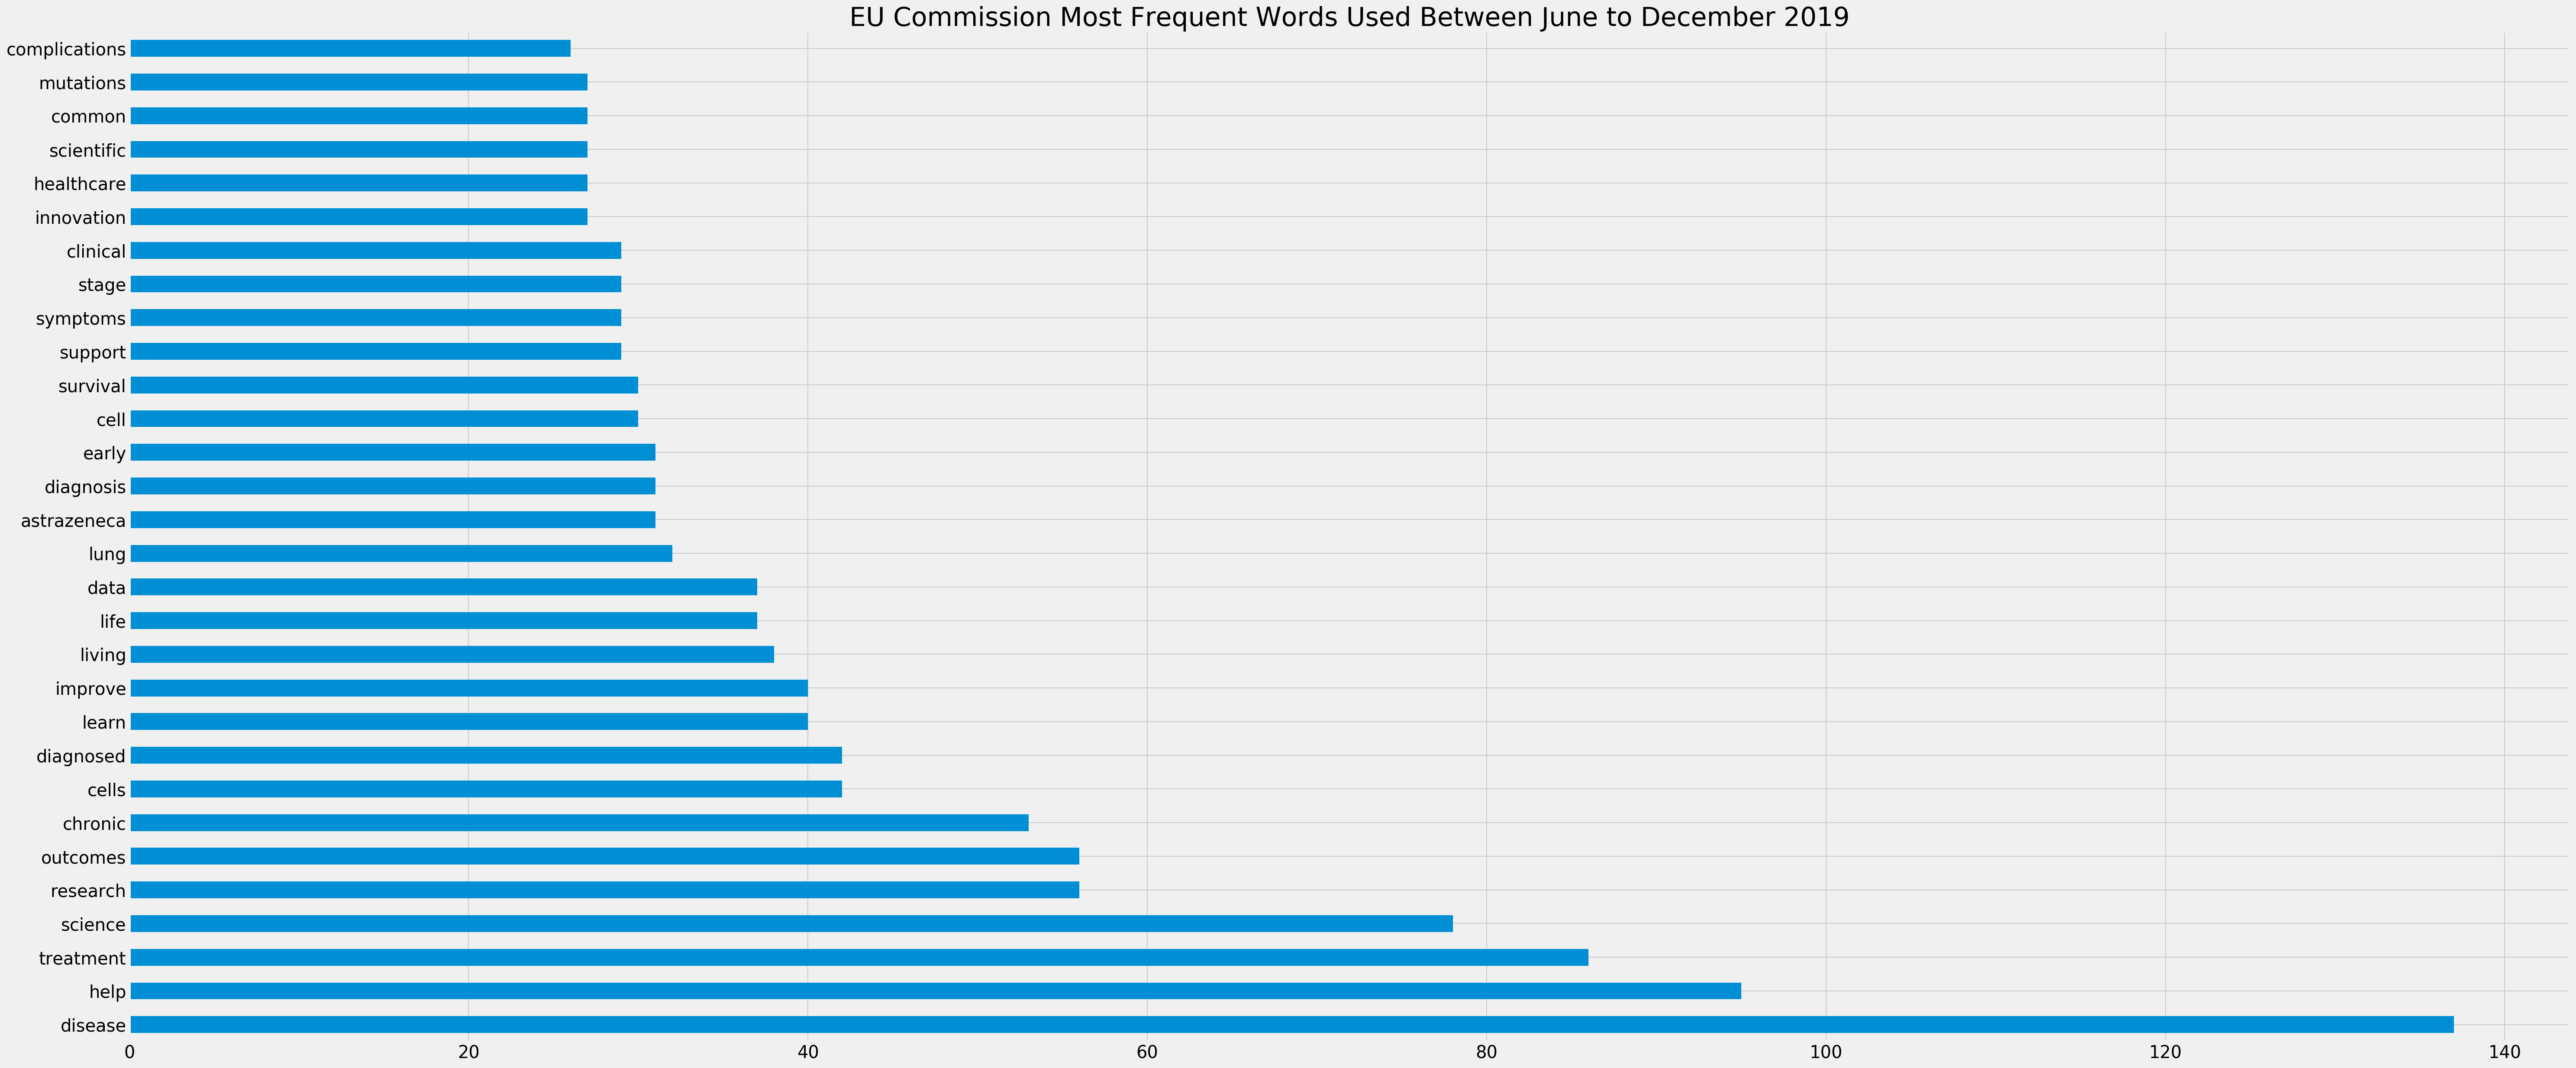

In [144]:
# Visualize the top words between in tweets
bigrams_2019.plot(y=[0, 1], kind="barh", figsize= (45,20), fontsize=20)
plt.title("EU Commission Most Frequent Words Used Between June to December 2019", fontsize=30)
# plt.legend(labels=["Life After Narcissism", "Raised By Narcissists"], fontsize =20)
# plt.savefig("../plots/EU_top_words_2019.png", bbox_inches = "tight", pad_inches =0.2 );

## Explore words in 2020

In [149]:
# get the top words in 2020
bigrams_2020 = words.top_words(cvec, df[df['date'] > '2020-01-01']['text'])

In [150]:
# color code solidarity word
solidarity = bigrams_2020.keys().str.contains("collaboration")
highlight = ['#77f56b' if (x == True) else "#3c8fd0" for x in solidarity]

In [ ]:
# Visualize the top words between each subreddit
bigrams_2020.plot(y=[0, 1], kind="barh", color =highlight, figsize= (45,20), fontsize=20)
plt.title("EU Commission Most Frequent Words Used Between January to June 2020", fontsize=30)
# plt.savefig("../plots/EU_top_words_2020.png", bbox_inches = "tight", pad_inches =0.2);

Text(0.5, 1.0, 'EU Commission Most Frequent Words Used Between January to June 2020')

## Filter for tweets that mention solidarity and collaboration

In [130]:
keywords = ["solidarity", "collaboration", "accessible"]

In [131]:
# selecting for tweets that contain solidarity or collaboration
collab_tweets = words.select_tweets(df, 'text', keywords)

In [99]:
# write to csv
collab_tweets.to_csv("../data/EU_collab_tweets.csv", index = False)

In [132]:
# Filter for tweets before and after 2020
collab_tweets["before_2020"] = np.where(collab_tweets['date'] > '2020-01-01', "After 2020", "Before 2020")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Number of Tweets')

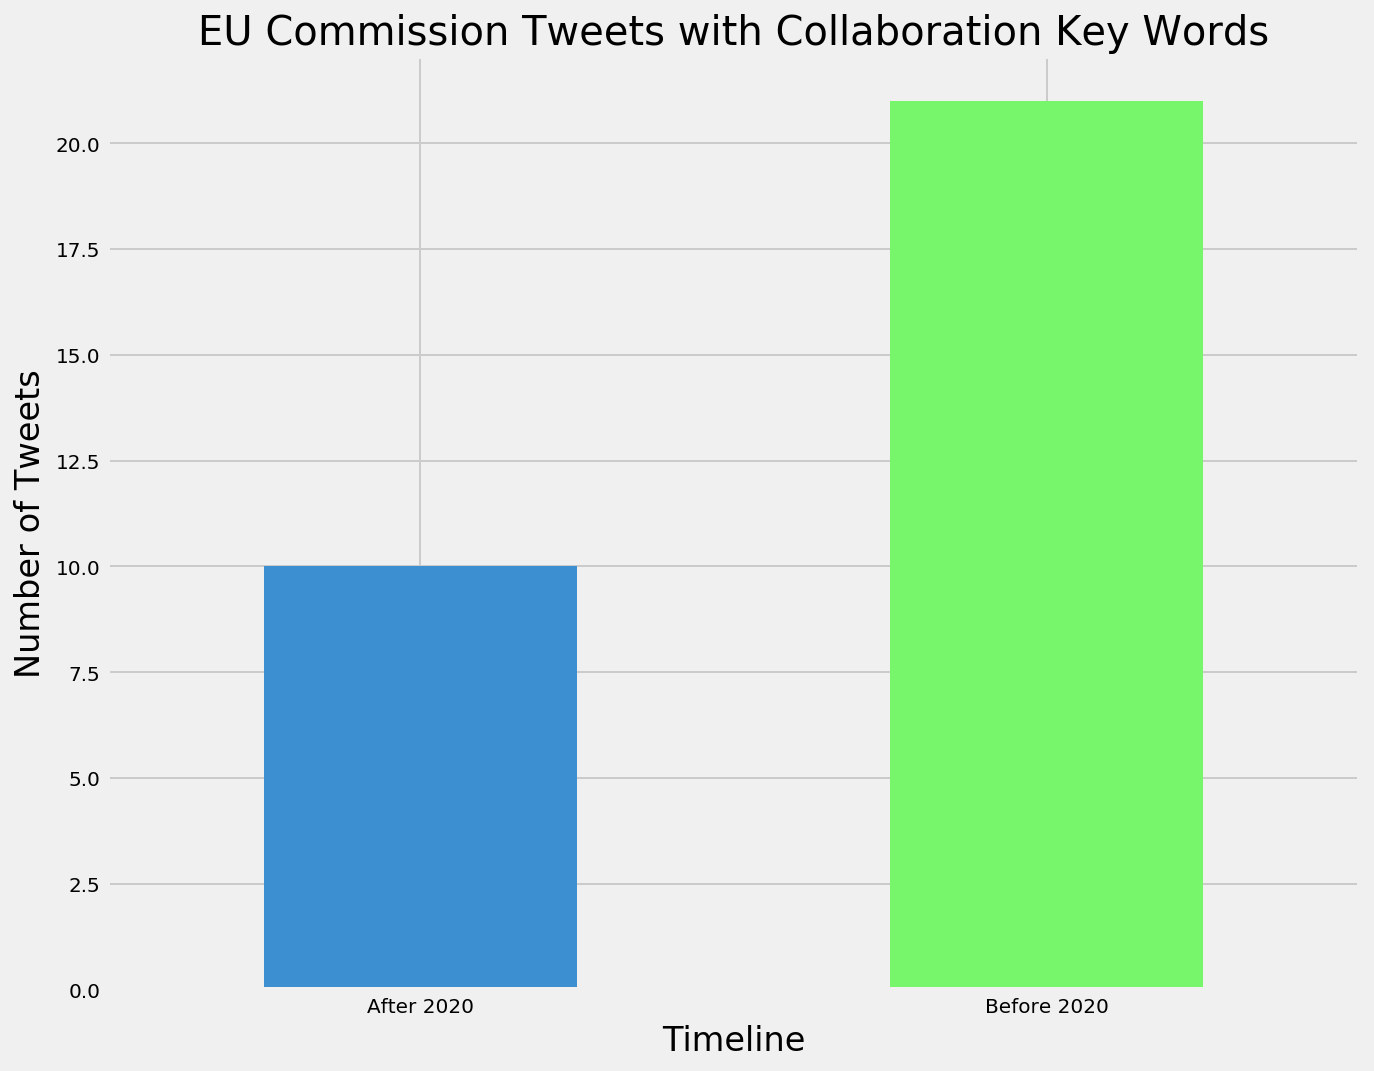

In [133]:
# Visualize the top words between each subreddit
collab_tweets.groupby('before_2020').count()['text'].T.sort_values(0, ascending=True).plot(figsize= (10,8), kind="bar", colors=["#3c8fd0", '#77f56b'] , fontsize=10)
plt.title("EU Commission Tweets with Collaboration Key Words", fontsize=20)
plt.xticks(rotation=0)
plt.xlabel("Timeline")
plt.ylabel("Number of Tweets")
# plt.savefig("../plots/EU_keyword_tweets.png");